In [2]:
from ultralytics import YOLO
import supervision as sv
import cv2
import numpy as np
import time

In [3]:
model = YOLO("yolo12n.pt")

In [5]:
class_names = model.model.names
vehicles_class_id = [2, 3, 5, 7]

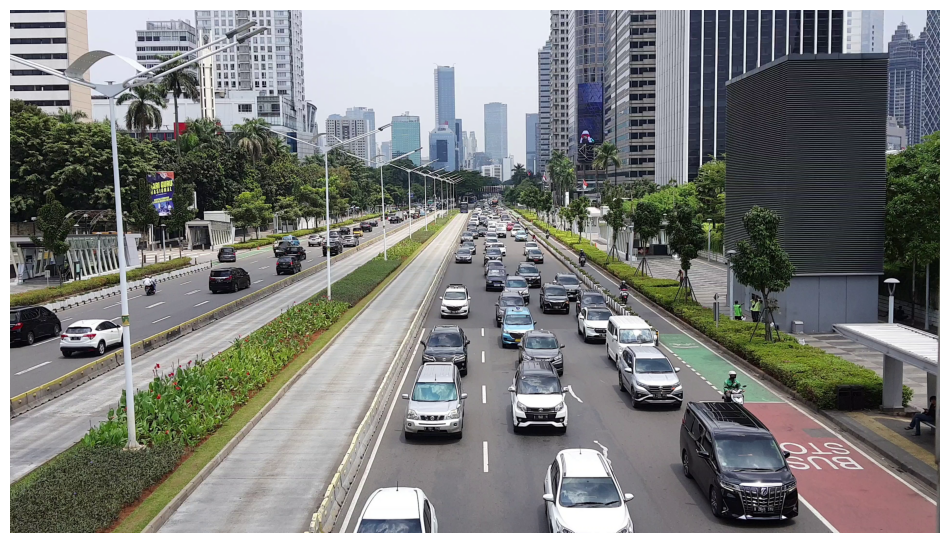

In [6]:
frame_generator = sv.get_video_frames_generator("./Videos/test_video.mp4")
iter_frames = iter(frame_generator)
frame = next(iter_frames)
sv.plot_image(frame)


0: 384x640 20 cars, 1 truck, 299.2ms
Speed: 8.3ms preprocess, 299.2ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)


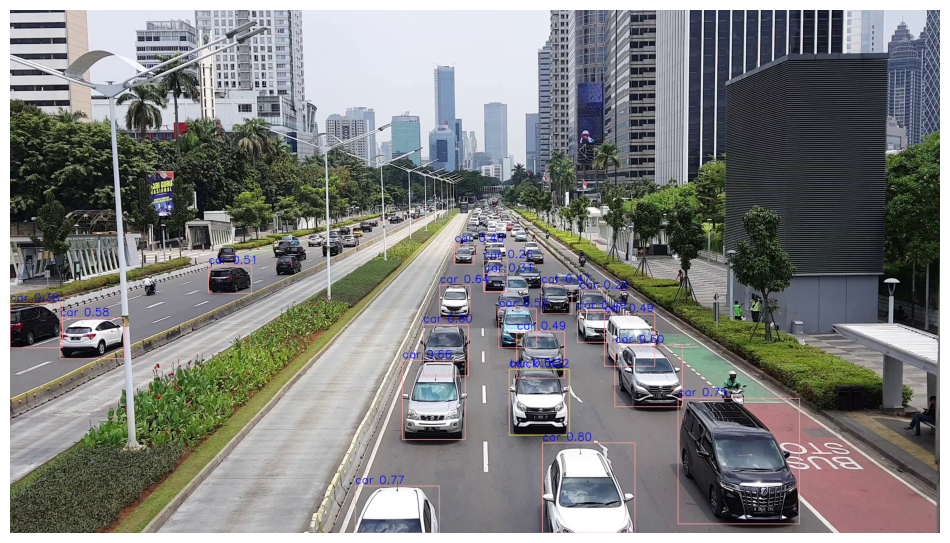

In [25]:
results = model(frame, conf=0.25)[0]

dets = sv.Detections.from_ultralytics(results)
dets = dets[np.isin(dets.class_id, vehicles_class_id)]
box_annotator = sv.BoxAnnotator(thickness=2)
labels = [f"{class_names[class_id]} {confidence:0.2f}" for confidence, class_id in zip(dets.confidence, dets.class_id)]
annotaed_frame = box_annotator.annotate(scene=frame.copy(), detections=dets)

for box,label in zip(dets.xyxy, labels):
    cv2.putText(annotaed_frame, label, (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,0,0), 2)

sv.plot_image(annotaed_frame)

In [26]:
sv.VideoInfo.from_video_path("./Videos/test_video.mp4")

VideoInfo(width=3840, height=2160, fps=30, total_frames=470)

In [40]:
line = [sv.Point(0, 400), sv.Point(640, 400)]
byte_tracker = sv.ByteTrack(frame_rate=30)
line_counter = sv.LineZone(line[0], line[1])
line_zone_annotator = sv.LineZoneAnnotator(thickness=2, text_thickness=2, text_scale=1)
box_annotator = sv.BoxAnnotator(thickness=2)


In [41]:
def process_frame(frame):
    results = model(frame)[0]
    dets = sv.Detections.from_ultralytics(results)
    dets = dets[np.isin(dets.class_id, vehicles_class_id)]
    dets = byte_tracker.update_with_detections(detections=dets)
    labels = [f"{class_names[class_id]} {confidence:0.2f} {track_id}" for confidence, class_id, track_id in zip(dets.confidence, dets.class_id, dets.tracker_id)]
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=dets)

    for box,label in zip(dets.xyxy, labels):
        cv2.putText(annotated_frame, label, (int(box[0]), int(box[1]-10)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,0,0), 2)
    
    line_counter.trigger(dets)
    annotated_frame = line_zone_annotator.annotate(annotated_frame, line_counter=line_counter)
    return annotated_frame


In [42]:
videos_path = "./Videos/test_video.mp4"
vid_cap = cv2.VideoCapture(videos_path)
frame_generator = sv.get_video_frames_generator(videos_path)

while True:
    success, frame = vid_cap.read()
    if not success:
        break
    frame = cv2.resize(frame, (640, 480))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    processed_frame = process_frame(frame)
    cv2.imshow("processed video", processed_frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
vid_cap.release()
cv2.destroyAllWindows()
print(f"in count: {line_counter.in_count}")
print(f"out count: {line_counter.out_count}")


0: 480x640 1 person, 16 cars, 2 buss, 374.0ms
Speed: 28.4ms preprocess, 374.0ms inference, 6.9ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 2 buss, 369.6ms
Speed: 3.2ms preprocess, 369.6ms inference, 8.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 19 cars, 1 truck, 397.3ms
Speed: 3.2ms preprocess, 397.3ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 18 cars, 1 truck, 372.5ms
Speed: 5.5ms preprocess, 372.5ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 cars, 1 bus, 296.8ms
Speed: 2.8ms preprocess, 296.8ms inference, 6.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 17 cars, 1 truck, 411.9ms
Speed: 2.5ms preprocess, 411.9ms inference, 6.5ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 2 buss, 326.6ms
Speed: 3.8ms preprocess, 326.6ms inference, 6.4ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 15 cars, 1 bus, 2 tr

In [39]:
totalcount = line_counter.in_count + line_counter.out_count
vid_info = sv.VideoInfo.from_video_path(videos_path)
video_duration_seconds = vid_info.total_frames / vid_info.fps
print(f"Video duration (seconds): {video_duration_seconds}")
traffic_vol_per_min = totalcount / (video_duration_seconds / 60)
print(f"Traffic volume per minute: {traffic_vol_per_min}")

Video duration (seconds): 15.666666666666666
Traffic volume per minute: 68.93617021276596
